Постановка задачи

В этой же папке на диске лежит файл dataset.csv

Ваша задача провести анализ данных, построить и оценить модель классификации. Выбор метрик и моделей за вами. Решение должно быть загружено в формате .ipynb или .html

Оценка работ будет производиться по следующим критериям: 

- Качественный EDA
- Корректные и обоснованные трансформации данных
- Корректное и обоснованное обучение и оценка модели
- Качество кода и чистота jupyter notebook


Описание данных

Это набор данных HR. Задача состоит в том, чтобы проверить, получил ли сотрудник повышение или нет.
Названия колонок:
	•	employee_id
	•	department
	•	region
	•	education
	•	gender
	•	recruitment_channel
	•	nooftrainings
	•	age
	•	previousyearrating
	•	lengthofservice
	•	KPIs_met >80%
	•	awards_won?
	•	avgtrainingscore
	•	is_promoted

Если по названию колонки все еще не понятно, что в ней содержится, мы ожидаем, что вы сделаете свои предположения на основе анализа данных


In [40]:
import os
import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [41]:
df = pd.read_csv("dataset.csv")
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [42]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [43]:
df.describe(include='all')

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808,54808,52399,54808,54808,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
unique,NaN,9,34,3,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Sales & Marketing,region_2,Bachelor's,m,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,16840,12343,36669,38496,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,39195.830627,NaN,NaN,NaN,NaN,NaN,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,NaN,NaN,NaN,NaN,NaN,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,NaN,NaN,NaN,NaN,NaN,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,NaN,NaN,NaN,NaN,NaN,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,NaN,NaN,NaN,NaN,NaN,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000


In [44]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [46]:
missing_values = df.isnull().sum()

data_types = df.dtypes

In [47]:
miss_v_df = pd.DataFrame(zip(*[missing_values.index, missing_values.values, data_types.values]), columns=["columns_name", "missing_values", "data_types"])
miss_v_df

,columns_name,missing_values,data_types
0,employee_id,0,int64
1,department,0,object
2,region,0,object
3,education,2409,object
4,gender,0,object
5,recruitment_channel,0,object
6,no_of_trainings,0,int64
7,age,0,int64
8,previous_year_rating,4124,float64
9,length_of_service,0,int64


Категориальные данные: `department`, `region`, `education`, `gender`, `recruitment_channel`;

Числовые данные: `no_of_trainings`, `age`, `previous_year_rating`, `length_of_service`, `KPIs_met >80%`, `awards_won?`, `avg_training_score`, `is_promoted`;

`is_promoted` <- Наш таргет.

/var/folders/nn/6tfq3jb17_3ch80d_ms1jhshpmv9tw/T/ipykernel_16403/2483880474.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')
/var/folders/nn/6tfq3jb17_3ch80d_ms1jhshpmv9tw/T/ipykernel_16403/2483880474.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')
/var/folders/nn/6tfq3jb17_3ch80d_ms1jhshpmv9tw/T/ipykernel_16403/2483880474.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')
/var/folders/nn/6tfq3jb17_3ch80d_ms1jhshpmv9tw/T/ipy

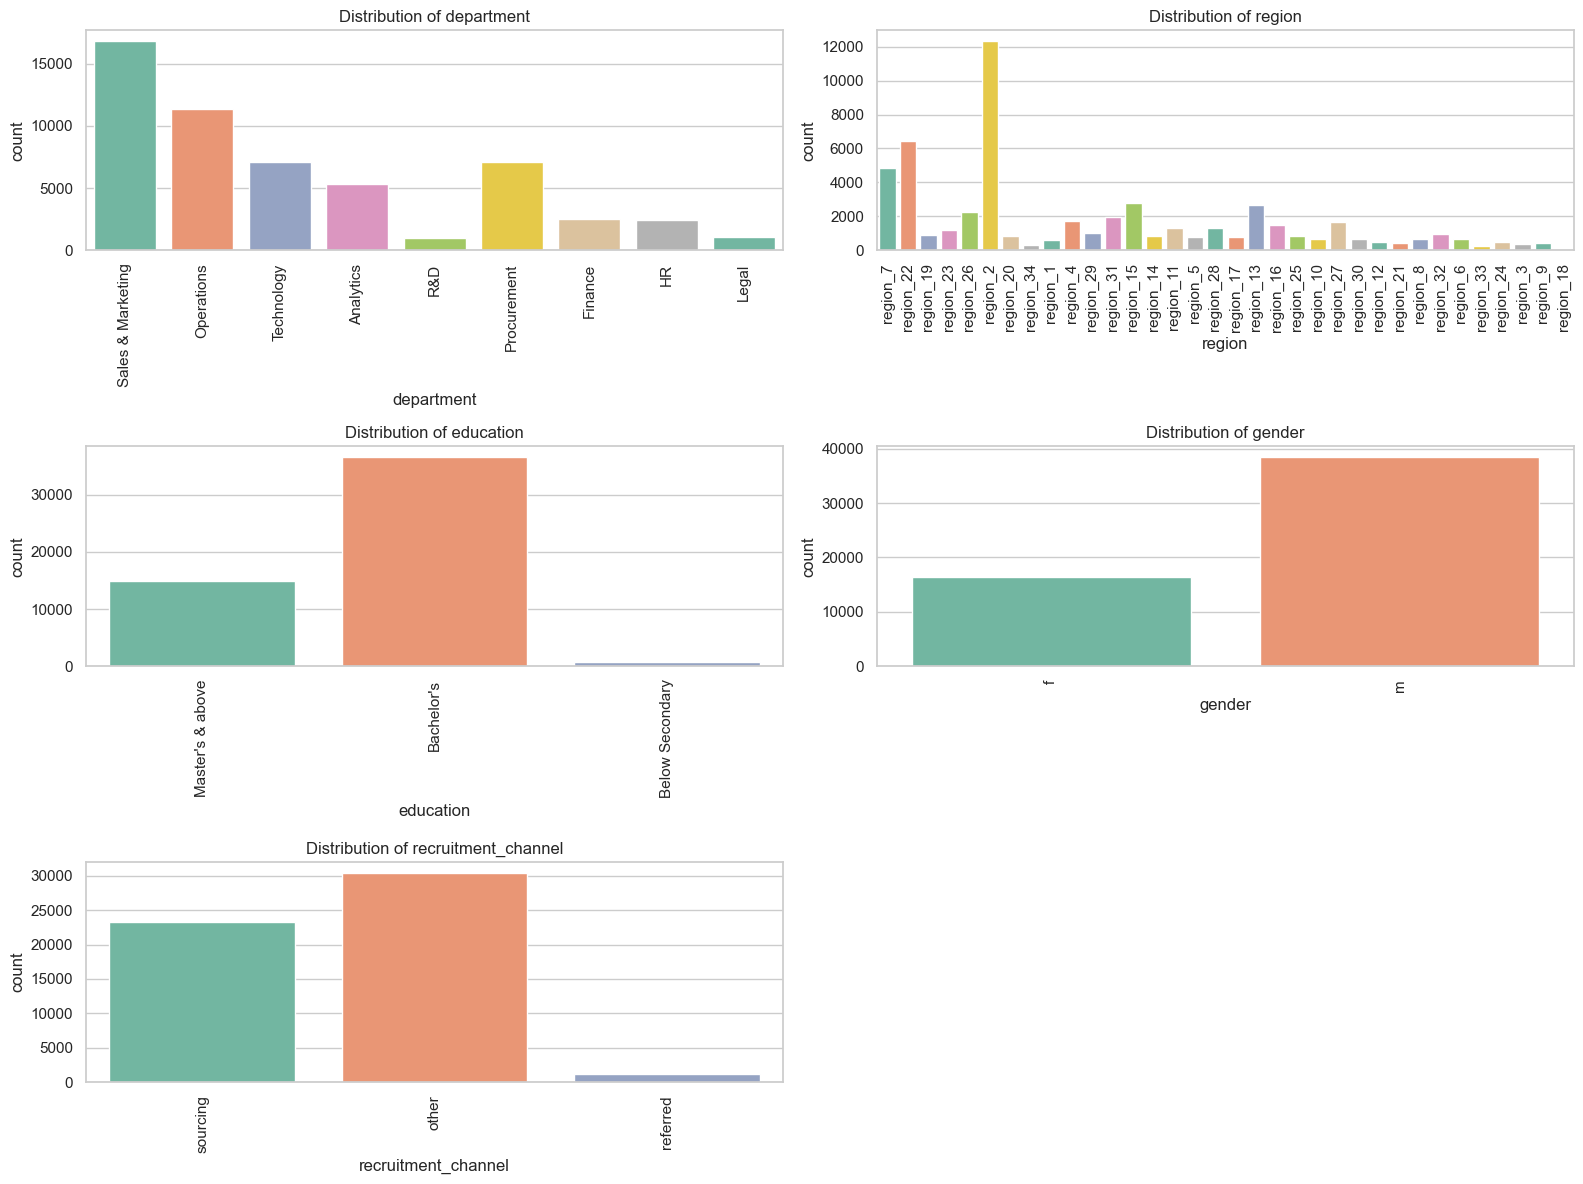

In [48]:
categorical_columns = ['department', 'region', 'education', 'gender', 'recruitment_channel']

plt.figure(figsize=(16, 12))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=column, palette='Set2')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
